# Libraries

In [1]:
import pandas as pd
import spacy
from tqdm import tqdm
import os
import math
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
import torchvision
from torchvision import models, transforms
# from transformers import ViTModel, ViTFeatureExtractor

In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
ENVIRON = "LOCAL"
CONFIG = {
    "LOCAL" : {
        "DF_PATH": "data/results.csv",
        "IMAGES_DIR_ROOT": "data",
        "FEATURE_MAPS_PATH": "feature_maps",
    },
    "KAGGLE" : {
        "DF_PATH": "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv",
        "IMAGES_DIR_ROOT": "/kaggle/input/flickr-image-dataset/flickr30k_images",
        "FEATURE_MAPS_PATH": "/kaggle/input/feature-maps"
    }
}

# Hyper Parameters

In [5]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

# Model
N_HEADS = 8
N_LAYERS = 12
EMBED_DIM = 512

# Data Processing

In [6]:
DF_PATH = CONFIG[ENVIRON]["DF_PATH"]
df = pd.read_csv(DF_PATH, delimiter="|")

df.dropna(inplace=True)

df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [7]:
df["comment"] = df[" comment"].apply(lambda x: str(x).strip()) \
                             .apply(lambda x: x.lower())
df.head()

,image_name,comment_number,comment,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many...","two young , white males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together .


# Tokenization

In [8]:
captions_list = df["comment"].to_list()
tokens_list = []
docs = list(nlp.pipe(captions_list, n_process=-1))
# for caption in tqdm(captions_list, desc="Vocab Building"):
#     tokens = nlp(caption)
#     tokens = list(map(lambda x: x.text, tokens))
#     vocab.update(tokens)
for doc in tqdm(docs, desc="Document Processing"):
    tokens = [token.text for token in doc]
    tokens_list.append(tokens)
df["tokens"] = tokens_list

Document Processing: 100%|██████████| 158914/158914 [00:01<00:00, 147535.92it/s]


In [9]:
caption_length = df["tokens"].apply(lambda x: len(x))
max_len = 25
bool_map = (caption_length <= max_len)
print("No. of rows -", df[bool_map].shape[0])
df = df[bool_map].reset_index(drop=True)

No. of rows - 153245


# Vocabulary

In [10]:
vocab = set()
tokens_list = df["tokens"].to_list()
for tokens in tqdm(tokens_list, desc="Vocab Building"):
    vocab.update(tokens)

Vocab Building: 100%|██████████| 153245/153245 [00:00<00:00, 847780.91it/s]


In [11]:
START_TOKEN = "</start>"
END_TOKEN = "</end>"
PAD_TOKEN = "</pad>"

vocab.add(START_TOKEN)
vocab.add(END_TOKEN)
vocab.add(PAD_TOKEN)

vocab = sorted(list(vocab)) # Just incase
vocab_size = len(vocab)

print("Vocab Size -", vocab_size)

Vocab Size - 17683


In [12]:
token_to_idx = {token: i for i, token in enumerate(vocab)}
idx_to_token = {v: k for k, v in token_to_idx.items()}

In [13]:
# max_len += 2 # # +2 due to START and END tokens
max_len = 27 # +2 due to START and END tokens

In [14]:
# df.drop(columns=["comment_number", "comment"], inplace=True)
df["tokens"] = df["tokens"].apply(lambda x: [START_TOKEN, ] + x + [END_TOKEN, ])
df["tokens"] = df["tokens"].apply(lambda x: x + [PAD_TOKEN, ] * (max_len - len(x)))
df.head()

,image_name,comment_number,comment,comment,tokens
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys with shaggy hair look at their ...,"[</start>, two, young, guys, with, shaggy, hai..."
1,1000092795.jpg,1,"Two young , White males are outside near many...","two young , white males are outside near many ...","[</start>, two, young, ,, white, males, are, o..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard .,"[</start>, two, men, in, green, shirts, are, s..."
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden .,"[</start>, a, man, in, a, blue, shirt, standin..."
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together .,"[</start>, two, friends, enjoy, time, spent, t..."


# Dataset & DataLoader

In [15]:
# df = df.sample(frac=.05).reset_index(drop=True)

In [16]:
def get_train_test_split(df, test_size):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
    
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    return train_df, val_df
train_df, val_df = get_train_test_split(df, test_size=.2)

#### Old Implementation - Ignore (Don't Remove)

In [17]:
# class CaptionsDataset(Dataset):
#     def __init__(self, df, token_to_idx, image_transforms):
#         self.df = df
#         self.token_to_idx = token_to_idx
#         self.image_transforms = image_transforms
#         resnet = models.resnet18(pretrained=True)
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])
#     def __len__(self):
#         return len(self.df)
#     def _encode_tokens(self, tokens):
#         return [self.token_to_idx[token] for token in tokens]
#     def _get_image_features(self, x):
#         with torch.no_grad():
#             image_features = self.resnet(x.unsqueeze(0))
#         return image_features.squeeze()
#     def __getitem__(self, i):
#         image_name, tokens = self.df.loc[i, "image_name"], self.df.loc[i, "tokens"]
#         target_tokens = tokens[1:] + [PAD_TOKEN, ]
#         image_path = os.path.join("data", "flickr30k_images", image_name)
#         image = Image.open(image_path)
#         image = self.image_transforms(image)
#         tokens = self._encode_tokens(tokens)
#         target_tokens = self._encode_tokens(target_tokens)
#         tokens = torch.tensor(tokens, dtype=torch.long)
#         target_tokens = torch.tensor(target_tokens, dtype=torch.long)
#         image_features = self._get_image_features(image)
#         return image_features, tokens, target_tokens

In [18]:
# train_dataset = CaptionsDataset(train_df, token_to_idx, transform)
# val_dataset = CaptionsDataset(val_df, token_to_idx, transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# a, b, c = next(iter(train_loader))
# a.size(), b.size(), c.size()

#### New Implementation

In [19]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [20]:
resnet_model = models.resnet18(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-2]).to(device)

def get_feature_map(x):
    if x.ndimension() == 3:
        x = x.unsqueeze(0)
    with torch.no_grad():
        feature_map = resnet_model(x.to(device))
    if feature_map.ndimension() == 4:
        feature_map = feature_map.squeeze()
    feature_map = feature_map.permute(1, 2, 0)
    channels_size = feature_map.size()[-1]
    feature_map = feature_map.view(1, -1, channels_size)
    return feature_map

    
# vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    
# def get_feature_map(x):
#     if x.ndimension() == 3:
#         x = x.unsqueeze(0)
#     with torch.no_grad():
#         inputs = vit_feature_extractor(images=x, return_tensors="pt")
#         outputs = vit_model(**inputs)
#     features = outputs.last_hidden_state
#     return features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [21]:
# import pickle
image_names = set(df["image_name"].to_list())
feature_maps = {}
for image_name in tqdm(image_names, desc="ResNet Feature Maps"):
    image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
    image = Image.open(image_path)
    image = transform(image)
    feature_map = get_feature_map(image)
    feature_maps[image_name] = feature_map
# feature_map_path = os.path.join("resnet18-long-seq")
# with open(feature_map_path, "wb") as f:
#     pickle.dump(feature_maps, f)

# import pickle
# image_names = set(df["image_name"].to_list())
# feature_maps = {}
# for image_name in tqdm(image_names, desc="ViT Feature Extractor"):
#     image_path = os.path.join("data", "flickr30k_images", image_name)
#     image = Image.open(image_path)
#     image = transform(image)
#     feature_map = get_feature_map(image)
#     feature_maps[image_name] = feature_map

ResNet Feature Maps: 100%|██████████| 31783/31783 [07:19<00:00, 72.24it/s]


In [22]:
class CaptionsDataset(Dataset):
    def __init__(self, df, token_to_idx, feature_maps=None):
        
        self.df = df
        self.token_to_idx = token_to_idx
        self.feature_maps = feature_maps
        
    def __len__(self):
        return len(self.df)
    def _encode_tokens(self, tokens):
        return [self.token_to_idx[token] for token in tokens]
    def _process_image(self, image_name):
        image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
        image = Image.open(image_path)
        image = transform(image)
        image_features = get_feature_map(image)
        return image_features
    def __getitem__(self, i):
        image_name, tokens = self.df.loc[i, "image_name"], self.df.loc[i, "tokens"]
        target_tokens = tokens[1:] + [PAD_TOKEN, ]
        tokens = self._encode_tokens(tokens)
        target_tokens = self._encode_tokens(target_tokens)
        tokens = torch.tensor(tokens, dtype=torch.long)
        target_tokens = torch.tensor(target_tokens, dtype=torch.long)
        
        if self.feature_maps is not None:
            image_features = self.feature_maps[image_name]
        else:
            image_features = self._process_image(image_name)
        image_features = image_features.squeeze()
        
        return image_features, tokens, target_tokens

In [23]:
# FEATURE_MAPS_FILENAME = os.path.join(CONFIG[ENVIRON]["FEATURE_MAPS_PATH"], "resnet18-long-seq")
# FEATURE_MAPS_FILENAME = os.path.join("resnet18-long-seq")
# feature_maps = pd.read_pickle(FEATURE_MAPS_FILENAME)

In [24]:
def get_datasets(df, token_to_idx, feature_maps):
    train_df, val_df = get_train_test_split(df, test_size=.2)
    train_dataset = CaptionsDataset(train_df, token_to_idx, feature_maps)
    val_dataset = CaptionsDataset(val_df, token_to_idx, feature_maps)
    return train_dataset, val_dataset

def get_dataloaders(df, token_to_idx, feature_maps, batch_size):
    train_dataset, val_dataset = get_datasets(df, token_to_idx, feature_maps)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

# Model Architecture

In [25]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, p=0.1, max_length=max_len):
        super(PositionalEmbedding, self).__init__()
        self.dropout_layer = nn.Dropout(p)
        encoding = torch.zeros(max_length, embed_dim)
        positions = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        scale_factor = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        encoding[:, 0::2] = torch.sin(positions * scale_factor)
        encoding[:, 1::2] = torch.cos(positions * scale_factor)
        encoding = encoding.unsqueeze(0)
        self.register_buffer('encoding', encoding)
    def forward(self, x):
        if self.encoding.size(0) < x.size(0):
            self.encoding = self.encoding.repeat(x.size(0), 1, 1).to(device)

        self.encoding = self.encoding[:x.size(0), :, :]

        x = x + self.encoding

        return self.dropout_layer(x)

In [26]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, n_heads, n_layers, vocab_size, embed_dim):
        super(ImageCaptioningModel, self).__init__()

        self.position_encoder = PositionalEmbedding(embed_dim, 0.1)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=n_heads)
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=n_layers)
        
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.output_layer = nn.Linear(embed_dim, vocab_size)
        
        self._initialize_weights()

    def _initialize_weights(self, param_range=0.1):
        self.embedding.weight.data.uniform_(-param_range, param_range)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-param_range, param_range)

    def _create_masks(self, size, decoder_input):
        
        causal_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        causal_mask = causal_mask.float().masked_fill(causal_mask == 0, float('-inf')).masked_fill(causal_mask == 1, float(0.0))

        pad_mask = decoder_input.float().masked_fill(decoder_input == 0, float(0.0)).masked_fill(decoder_input > 0, float(1.0))
        pad_mask_bool = decoder_input == 0

        return causal_mask, pad_mask, pad_mask_bool

    def forward(self, image_features, decoder_input):

        image_features = image_features.permute(1, 0, 2) # (num_patches, batch_size, embed_dim) or (feature_map_size, batch_size, num_channels)
        
        decoder_input_embed = self.embedding(decoder_input) * math.sqrt(self.embed_dim)
        decoder_input_embed = self.position_encoder(decoder_input_embed)
        
        decoder_input_embed = decoder_input_embed.permute(1, 0, 2)
        causal_mask, pad_mask, pad_mask_bool = self._create_masks(decoder_input.size(1), decoder_input)

        causal_mask = causal_mask.to(device)
        pad_mask = pad_mask.to(device)
        pad_mask_bool = pad_mask_bool.to(device)

        decoder_output = self.decoder(tgt=decoder_input_embed, memory=image_features, tgt_mask=causal_mask, tgt_key_padding_mask=pad_mask_bool)
        
        output = self.output_layer(decoder_output)
        return output, pad_mask

# Training & Validation Loop

In [27]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc="Training")
    for image_features, tokens, target_tokens in progress_bar:

        optimizer.zero_grad()
        
        image_features = image_features.to(device)
        tokens = tokens.to(device)
        target_tokens = target_tokens.to(device)
        
        logits, padding_mask = model(image_features, tokens)
        logits = logits.permute(1, 2, 0)

        loss = criterion(logits, target_tokens)
        loss_masked = torch.mul(loss, padding_mask)

        batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

        progress_bar.set_postfix(batch_loss=batch_loss.item(), refresh=True)

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [28]:
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    progress_bar = tqdm(val_loader, desc="Validation")
    with torch.inference_mode():
        for image_features, tokens, target_tokens in progress_bar:
            
            image_features = image_features.to(device)
            tokens = tokens.to(device)
            target_tokens = target_tokens.to(device)

            logits, padding_mask = model(image_features, tokens)
            logits = logits.permute(1, 2, 0)

            loss = criterion(logits, target_tokens)
            loss_masked = torch.mul(loss, padding_mask)

            batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)

            total_loss += batch_loss.item()

            progress_bar.set_postfix(batch_loss=batch_loss.item(), refresh=True)

    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Model Training

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch : [{epoch + 1}/{num_epochs}]")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = val_epoch(model, val_loader, criterion, device)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, "best_model")
            print("Model saved!")

    print("Training Complete.")

In [30]:
criterion = nn.CrossEntropyLoss()

model = ImageCaptioningModel(N_HEADS, N_LAYERS, vocab_size, EMBED_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.3, patience=2)

In [31]:
train_loader, val_loader = get_dataloaders(df, token_to_idx, feature_maps, BATCH_SIZE)

In [32]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS, device)

Epoch : [1/30]


Training:   0%|          | 0/3832 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation: 100%|██████████| 958/958 [00:28<00:00, 33.66it/s, batch_loss=2.09]


Training Loss: 2.4421
Validation Loss: 2.0562
Current Learning Rate: 1e-05
Model saved!
Epoch : [2/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.67it/s, batch_loss=1.96]


Training Loss: 1.9965
Validation Loss: 1.9011
Current Learning Rate: 1e-05
Model saved!
Epoch : [3/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.96it/s, batch_loss=1.88]


Training Loss: 1.8740
Validation Loss: 1.8171
Current Learning Rate: 1e-05
Model saved!
Epoch : [4/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.77it/s, batch_loss=1.83]


Training Loss: 1.7947
Validation Loss: 1.7616
Current Learning Rate: 1e-05
Model saved!
Epoch : [5/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.97it/s, batch_loss=1.79]


Training Loss: 1.7355
Validation Loss: 1.7192
Current Learning Rate: 1e-05
Model saved!
Epoch : [6/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.81it/s, batch_loss=1.76]


Training Loss: 1.6868
Validation Loss: 1.6856
Current Learning Rate: 1e-05
Model saved!
Epoch : [7/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.97it/s, batch_loss=1.74]


Training Loss: 1.6452
Validation Loss: 1.6579
Current Learning Rate: 1e-05
Model saved!
Epoch : [8/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.96it/s, batch_loss=1.72]


Training Loss: 1.6084
Validation Loss: 1.6354
Current Learning Rate: 1e-05
Model saved!
Epoch : [9/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.93it/s, batch_loss=1.7]


Training Loss: 1.5745
Validation Loss: 1.6154
Current Learning Rate: 1e-05
Model saved!
Epoch : [10/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.91it/s, batch_loss=1.69]


Training Loss: 1.5435
Validation Loss: 1.5995
Current Learning Rate: 1e-05
Model saved!
Epoch : [11/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.75it/s, batch_loss=1.68]


Training Loss: 1.5136
Validation Loss: 1.5846
Current Learning Rate: 1e-05
Model saved!
Epoch : [12/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.00it/s, batch_loss=1.66]


Training Loss: 1.4848
Validation Loss: 1.5712
Current Learning Rate: 1e-05
Model saved!
Epoch : [13/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.16it/s, batch_loss=1.65]


Training Loss: 1.4572
Validation Loss: 1.5603
Current Learning Rate: 1e-05
Model saved!
Epoch : [14/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.70it/s, batch_loss=1.64]


Training Loss: 1.4302
Validation Loss: 1.5504
Current Learning Rate: 1e-05
Model saved!
Epoch : [15/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.88it/s, batch_loss=1.63]


Training Loss: 1.4038
Validation Loss: 1.5411
Current Learning Rate: 1e-05
Model saved!
Epoch : [16/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.87it/s, batch_loss=1.62]


Training Loss: 1.3781
Validation Loss: 1.5328
Current Learning Rate: 1e-05
Model saved!
Epoch : [17/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.99it/s, batch_loss=1.61]


Training Loss: 1.3526
Validation Loss: 1.5270
Current Learning Rate: 1e-05
Model saved!
Epoch : [18/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.07it/s, batch_loss=1.6]


Training Loss: 1.3272
Validation Loss: 1.5199
Current Learning Rate: 1e-05
Model saved!
Epoch : [19/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.80it/s, batch_loss=1.59]


Training Loss: 1.3027
Validation Loss: 1.5150
Current Learning Rate: 1e-05
Model saved!
Epoch : [20/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.00it/s, batch_loss=1.59]


Training Loss: 1.2779
Validation Loss: 1.5105
Current Learning Rate: 1e-05
Model saved!
Epoch : [21/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.91it/s, batch_loss=1.59]


Training Loss: 1.2536
Validation Loss: 1.5065
Current Learning Rate: 1e-05
Model saved!
Epoch : [22/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.97it/s, batch_loss=1.59]


Training Loss: 1.2298
Validation Loss: 1.5039
Current Learning Rate: 1e-05
Model saved!
Epoch : [23/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.02it/s, batch_loss=1.58]


Training Loss: 1.2062
Validation Loss: 1.5008
Current Learning Rate: 1e-05
Model saved!
Epoch : [24/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.86it/s, batch_loss=1.59]


Training Loss: 1.1828
Validation Loss: 1.5004
Current Learning Rate: 1e-05
Model saved!
Epoch : [25/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.72it/s, batch_loss=1.58]


Training Loss: 1.1604
Validation Loss: 1.4992
Current Learning Rate: 1e-05
Model saved!
Epoch : [26/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.02it/s, batch_loss=1.59]


Training Loss: 1.1380
Validation Loss: 1.4984
Current Learning Rate: 1e-05
Model saved!
Epoch : [27/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.12it/s, batch_loss=1.59]


Training Loss: 1.1160
Validation Loss: 1.4994
Current Learning Rate: 1e-05
Epoch : [28/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.04it/s, batch_loss=1.6]


Training Loss: 1.0941
Validation Loss: 1.4996
Current Learning Rate: 1e-05
Epoch : [29/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 33.97it/s, batch_loss=1.6]


Training Loss: 1.0725
Validation Loss: 1.5008
Current Learning Rate: 3e-06
Epoch : [30/30]


Validation: 100%|██████████| 958/958 [00:28<00:00, 34.10it/s, batch_loss=1.61]


Training Loss: 1.0375
Validation Loss: 1.4962
Current Learning Rate: 3e-06
Model saved!
Training Complete.


In [33]:
def generate_caption(K, image_name):
    
    image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)

    model.eval()
    feature_map = feature_maps[image_name].to(device)


    input_tokens = [token_to_idx[PAD_TOKEN]] * max_len
    input_tokens[0] = token_to_idx[START_TOKEN]

    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)
    predicted_sentence = []
    
    with torch.no_grad():
        for eval_iter in range(0, max_len-1):

            logits, padding_mask = model.forward(feature_map, input_tokens)

            logits = logits[eval_iter, 0, :]

            values = torch.topk(logits, K).values.tolist()
            indices = torch.topk(logits, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = idx_to_token[next_word_index]

            input_tokens[:, eval_iter+1] = next_word_index


            if next_word == '</end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence))

In [34]:
model = torch.load("best_model").to(device)

/tmp/ipykernel_23/1491680750.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model").to(device)


In [35]:
i = 0



Predicted caption : 
a man is standing on a construction site .


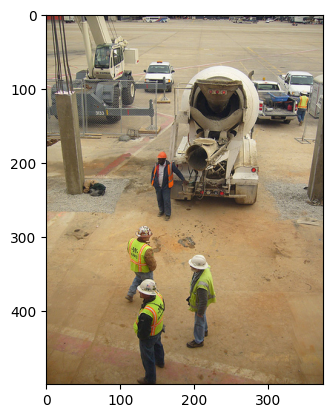

In [36]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a man in a white shirt and blue pants is jumping into a swimming pool .


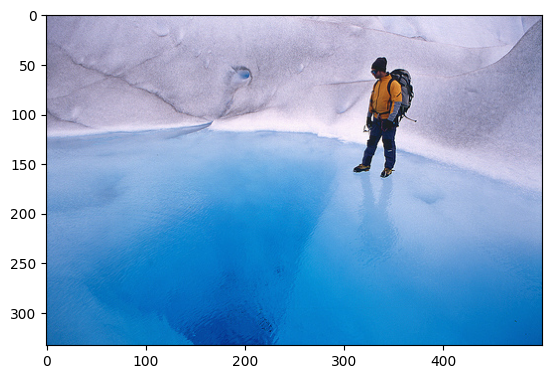

In [37]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a woman in a yellow shirt and a woman in a pink shirt are standing in a crowded street .


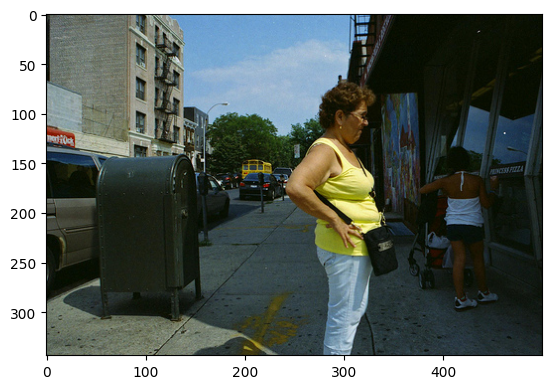

In [38]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a woman in a blue shirt is standing on a brick wall .


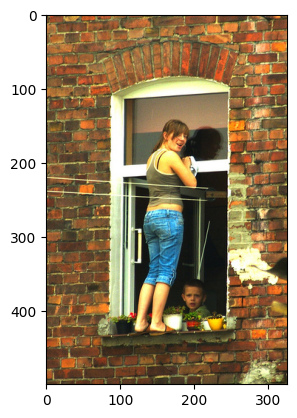

In [39]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a child is holding a green container with a green bucket on it .


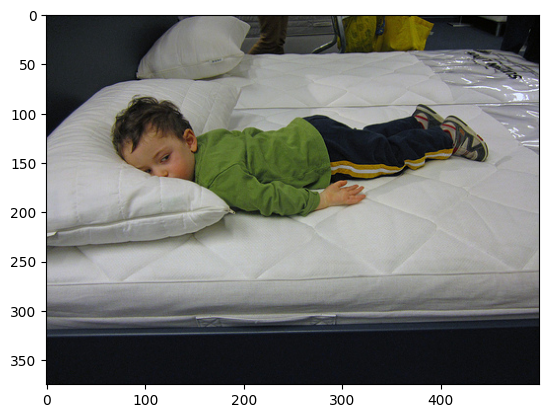

In [40]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a man in a black shirt is playing a guitar .


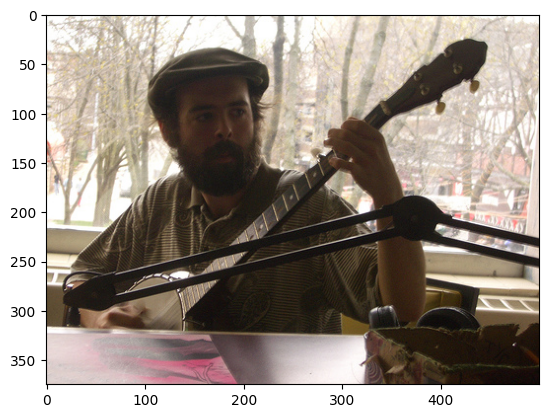

In [41]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a boy in a blue shirt is running through the water with a shovel in his hand .


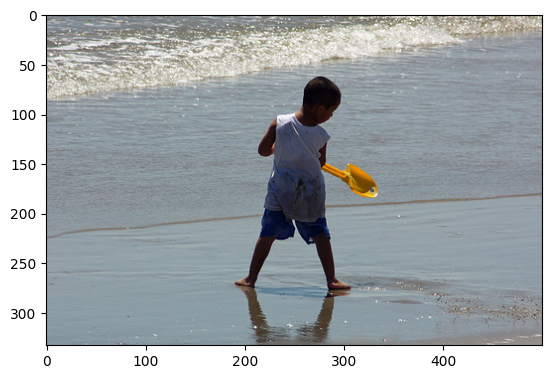

In [42]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])